In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

%matplotlib inline

In [46]:
# !pip3 install yfinance

In [5]:
import yfinance as yf

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [50]:
from datetime import datetime, timedelta

In [20]:
tickers = ['aapl', 'amzn', 'cl=f', 'tsla', 'btc-usd', 'dis']

start = datetime(2010, 1, 1)
end = datetime.today()

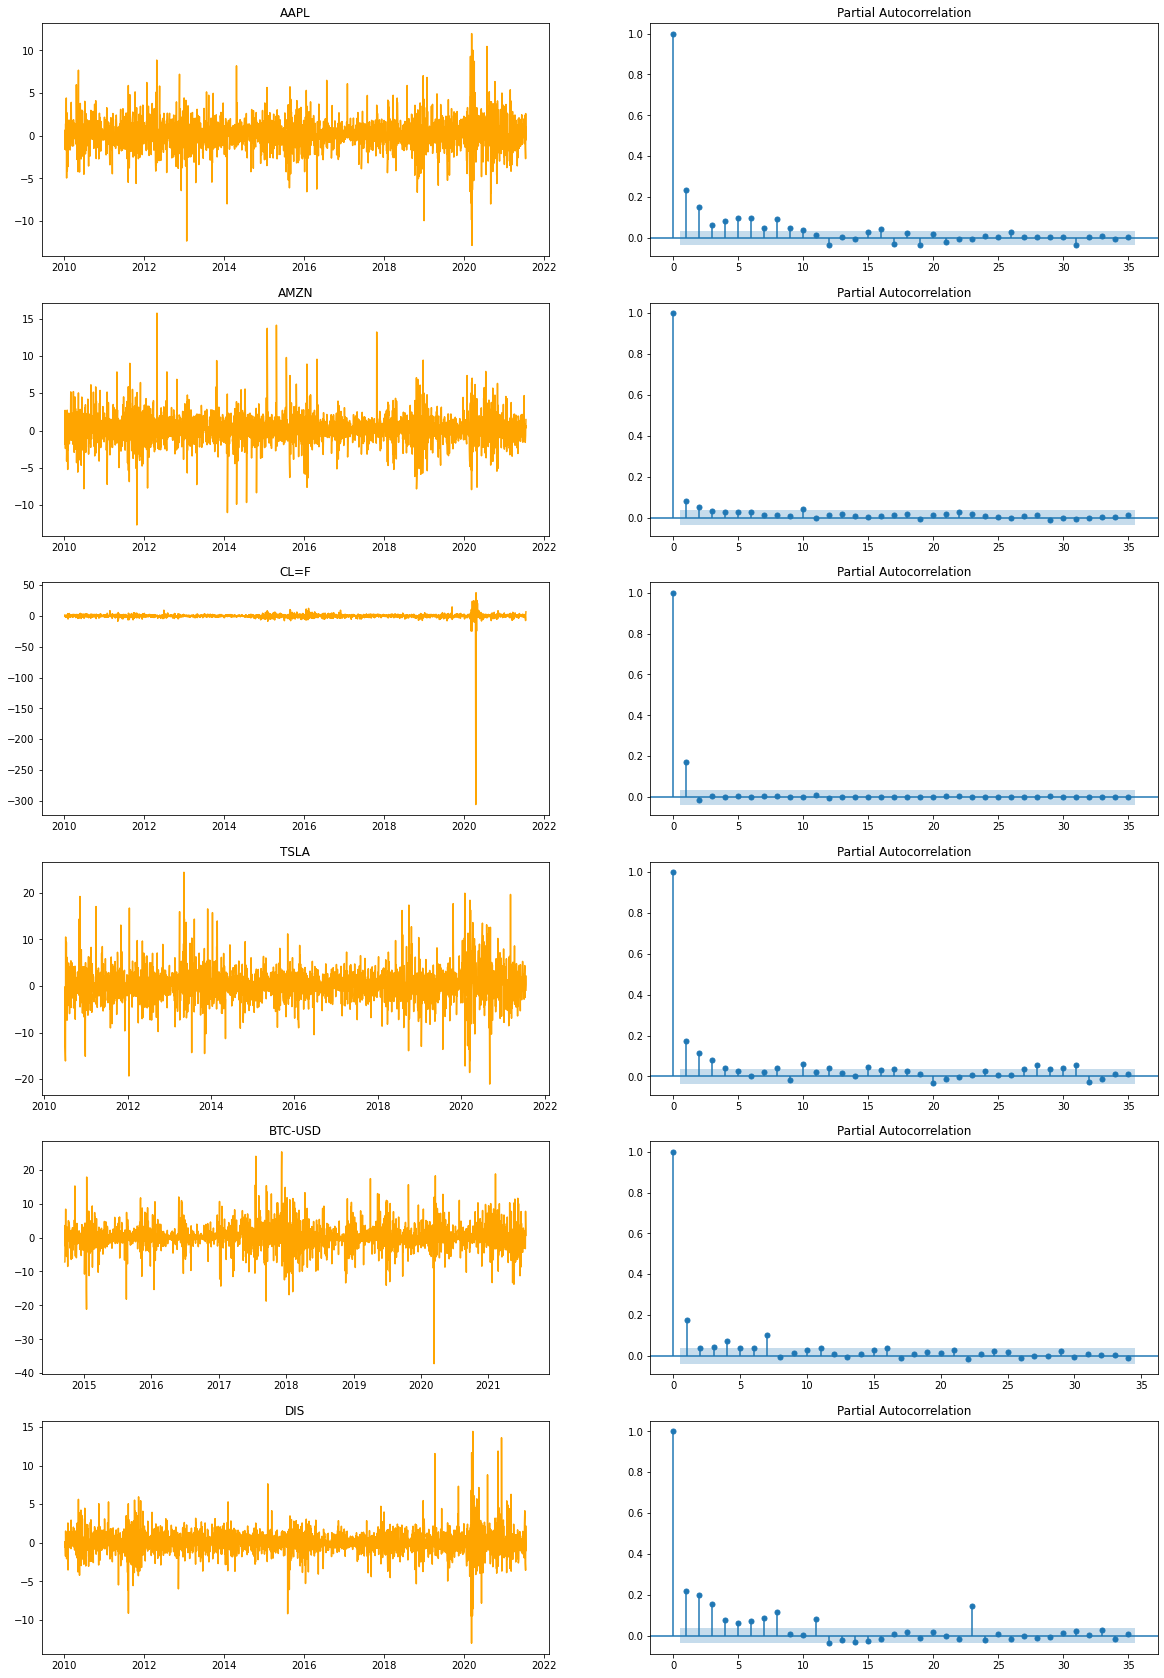

In [22]:
fig, axes = plt.subplots(nrows=len(tickers), ncols=2, figsize=(20,len(tickers)*5))

for i, ticker in enumerate(tickers):
    tckr = yf.Ticker(ticker)
    historical = tckr.history(start=start, 
                              end=end, 
                              interval="1d")
    
    returns = 100 * historical.Close.pct_change().dropna()
    axes[i][0].plot(returns, color='orange')
    axes[i][0].set_title(ticker.upper())
    plot_pacf(returns**2, ax=axes[i][1])
    
plt.show();

## BTC-USD

In [278]:
start = datetime(2010, 1, 1)
end = datetime.today()

tckr = 'btc-usd'

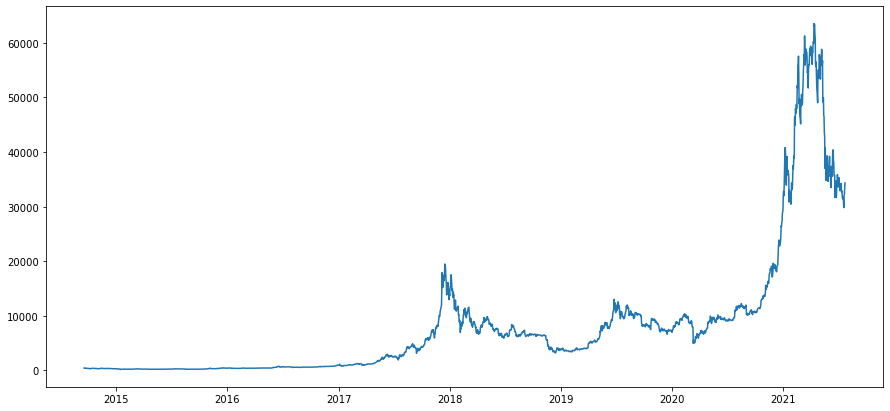

In [279]:
ticker = yf.Ticker(tckr)
ticker_historical = ticker.history(start=start, 
                                   end=end, 
                                   interval="1d")

plt.figure(figsize=(15,7))
plt.plot(ticker_historical.Close);

In [280]:
returns = 100 * ticker_historical.Close.pct_change().dropna()

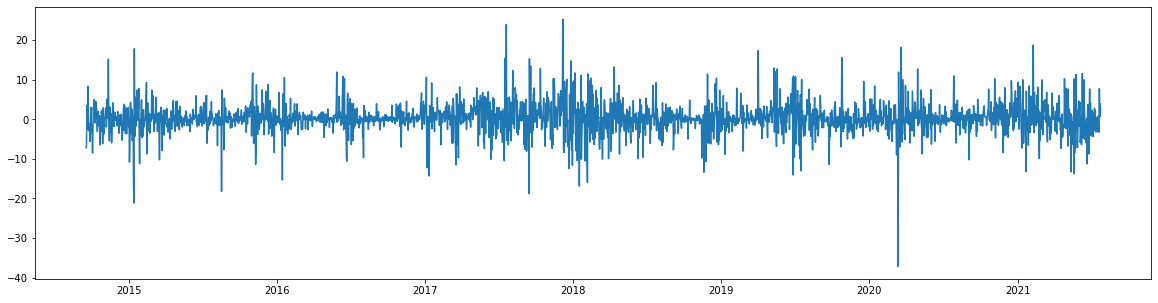

In [417]:
plt.figure(figsize=(20,5))
plt.plot(returns);

In [281]:
# split_time = datetime(2021, 7, 1)

# forecasting 1 year out (horizon = 365 days)
horizon = 365
split_time = end - timedelta(days=horizon)

In [282]:
x_train = returns[:split_time]
x_val = returns[split_time:]

In [283]:
len(x_val)

362

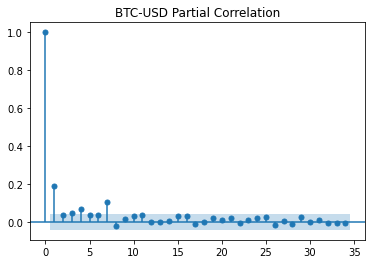

In [284]:
plot_pacf(x_train**2, 
          title=f'{tckr.upper()} Partial Correlation');

In [33]:
# conda install -c bashtage arch

### GARCH Model

In [176]:
from arch import arch_model

In [228]:
fsm = arch_model(x_train, vol='Garch', p=1, q=1)

In [229]:
fsm_fit = fsm.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 14452.158067683626
Iteration:      2,   Func. Count:     17,   Neg. LLF: 8186.722837568519
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6889.500511916123
Iteration:      4,   Func. Count:     31,   Neg. LLF: 5900.8715589856665
Iteration:      5,   Func. Count:     38,   Neg. LLF: 5714.265147109217
Iteration:      6,   Func. Count:     44,   Neg. LLF: 5707.599297549456
Iteration:      7,   Func. Count:     49,   Neg. LLF: 5707.562437441439
Iteration:      8,   Func. Count:     54,   Neg. LLF: 5707.550513745769
Iteration:      9,   Func. Count:     59,   Neg. LLF: 5707.550453692426
Iteration:     10,   Func. Count:     63,   Neg. LLF: 5707.550453692569
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5707.550453692426
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


In [230]:
fsm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -5707.55
Distribution:                  Normal   AIC:                           11423.1
Method:            Maximum Likelihood   BIC:                           11445.8
                                        No. Observations:                 2136
Date:                Sat, Jul 24 2021   Df Residuals:                     2132
Time:                        13:08:40   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1956  6.594e-02      2.966  3.013e-03 [6.636e-02,  0.325]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.6967      0.293      2.374  1.758e-02   [  0.122,  1.272]
alpha[1]       0.1495  3.585e-02      4.169  3.053e-05 [7.921e-02,  0.220]
beta[1]        0.8203  3.064e-02     26.773 6.654e-158   [  0.760,  0.880]
==========================================================================

Covariance estimator: robust
"""

In [231]:
fsm_fit.forecast(horizon=1).variance.values[-1][0]

4.7037646574615515

All coefficients seem to be statistically significant.

In [429]:
# rolling forecast

rolling_forecasts = []
test_size = len(x_val)

for i in range(test_size):
    train = btcusd_returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_forecasts.append(np.sqrt(pred.variance.values[-1][0]))

In [430]:
len(rolling_forecasts)

362

In [431]:
rolling_predictions = pd.Series(rolling_forecasts, index=x_val.index)

In [418]:
# plt.figure(figsize=(10,4))
# true, = plt.plot(btcusd_returns[split_time:])
# preds, = plt.plot(rolling_predictions)
# plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
# plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16);

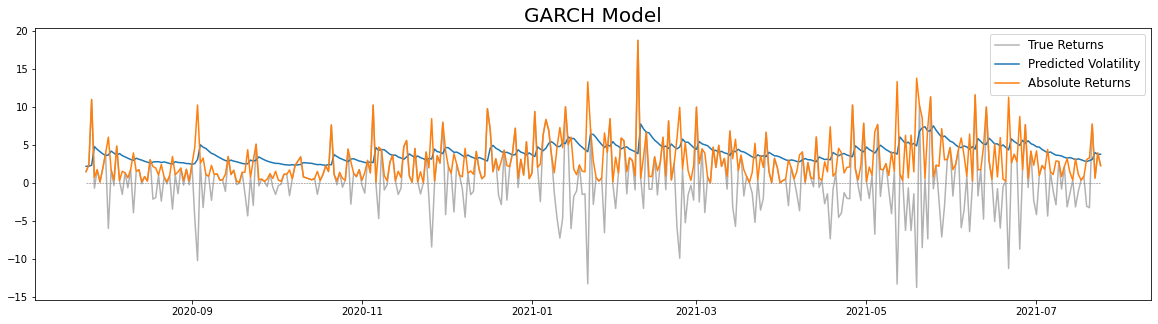

In [432]:
plt.figure(figsize=(20,5))
true, = plt.plot(x_val, color='gray', alpha=0.6)
preds, = plt.plot(rolling_predictions)
abs_true, = plt.plot(np.abs(x_val))
plt.hlines(y=0, 
           xmin=x_val.index[0],
           xmax=x_val.index[-1],
           color='black', alpha=0.6, ls='--', lw=0.5)
plt.title('GARCH Model', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility', 'Absolute Returns'], fontsize=12, loc='best');

In [436]:
from sklearn.metrics import mean_squared_error as mse
# from sklearn.metrics import mean_absolute_percentage_error

In [437]:
len(rolling_predictions)

362

In [438]:
mse(np.abs(x_val), rolling_predictions)

9.446044847854003

In [444]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))
    return mape

In [445]:
MAPE(np.abs(x_val), rolling_predictions)

9.237353608114987

### Single Layer DNN

In [276]:
import tensorflow as tf

In [289]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [345]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 100

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [413]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9))

model.fit(dataset, epochs=300, verbose=0)

In [414]:
forecast = []
idx = btcusd_returns.index

for t in range(len(x_val)):
    forecast.append(model.predict(btcusd_returns[idx[t]:idx[t+window_size-1]].values[np.newaxis]))
    
forecast = forecast[-len(x_val):]

results = np.array(forecast)[:, 0, 0]

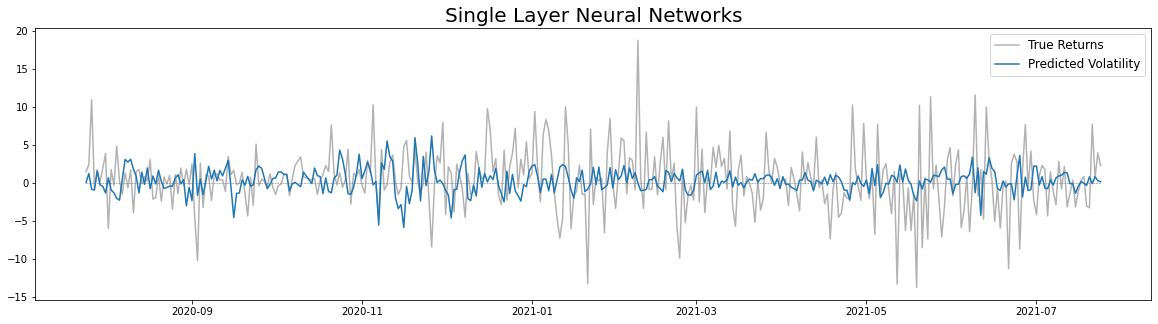

In [415]:
plt.figure(figsize=(20,5))
true, = plt.plot(x_val, color='gray', alpha=0.6)
preds, = plt.plot(pd.Series(results, index=x_val.index))
# abs_true, = plt.plot(np.abs(x_val))
plt.hlines(y=0, 
           xmin=x_val.index[0],
           xmax=x_val.index[-1],
           color='black', alpha=0.6, ls='--', lw=0.5)
plt.title('Single Layer Neural Networks', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=12, loc='best');

In [416]:
mse(x_val, results)

18.95159839359893

In [446]:
MAPE(x_val, results)

3.2332444525700046